<a href="https://colab.research.google.com/github/lulmer/DA-RNN_for_timeseries/blob/master/da_rnn_with_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DA RNN

Google Drive Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
cd drive/My\ Drive

[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


In [0]:
cd 'Colab Notebooks'

In [3]:
ls

'1- Les organisations-  M1.ppt'
 1.png
 20180625085224686.pdf
 2.png
 3.png
 aaaaaaaaaaaaaaaaaa.jpg
 aaaaaa.jpg
 aaaa.jpg
'AttestationDroits(1).pdf'
 B1.jpg
 bitcoin.csv
'Churn temporaire.ipynb'
'Colab Notebooks'/
 COMPANY-2.jpg
'Copie de David Laid DUP Program.xlsx'
'CORRECTION 5.docx'
 coucccccccccccccc.PNG
 d18fcb23-8f05-929c-857d-36b85fe855f4.pdf
'Employees (1).gsheet'
 Employees.gsheet
'exercice C.docx'
'Gestion projet'/
 gg.jpg
'Global Warming (1).pptx'
'Global Warming.pptx'
'Global warming represents the increase of temperature in the world.docx'
 IMG_20150223_190358710.jpg
 IMG_20150223_190414844.jpg
 IMG_20150223_190418536.jpg
 IMG_20150223_190433801.jpg
 IMG_20150223_190446268.jpg
 IMG_20150223_190502127.jpg
 IMG_20150223_190509058.jpg
 IMG_20150223_190511059.jpg
 IMG_20150223_190526696.jpg
 IMG_20150223_190534786.jpg
 IMG_20150223_190536373.jpg
 IMG_20150223_190537783.jpg
 IMG_20150223_190541415.jpg
 IMG_20150223_190543015.jpg
 IMG_20150223_190637814.jpg
 IMG_20150223_190646

## Hyper-parameters settings

In [0]:
dataroot = 'join2.csv'

batchsize = 30
nhidden_encoder = 64
nhidden_decoder = 64
ntimestep = 5
lr = 0.001
epochs = 110

## Model Architecture


In [0]:
import matplotlib.pyplot as plt

from torch.autograd import Variable

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F


class Encoder(nn.Module):
    """encoder in DA_RNN."""

    def __init__(self, T,
                 input_size,
                 encoder_num_hidden,
                 parallel=False):
        """Initialize an encoder in DA_RNN."""
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.T = T

        # Fig 1. Temporal Attention Mechanism: Encoder is LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        # Construct Input Attention Mechanism via deterministic attention model
        # Eq. 8: W_e[h_{t-1}; s_{t-1}] + U_e * x^k
        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T - 1,
            out_features=1
        )

    def forward(self, X):
        """forward.

        Args:
            X: input data

        """
        X_tilde = Variable(X.data.new(
            X.size(0), self.T - 1, self.input_size).zero_())
        X_encoded = Variable(X.data.new(
            X.size(0), self.T - 1, self.encoder_num_hidden).zero_())

        # Eq. 8, parameters not in nn.Linear but to be learnt
        # v_e = torch.nn.Parameter(data=torch.empty(
        #     self.input_size, self.T).uniform_(0, 1), requires_grad=True)
        # U_e = torch.nn.Parameter(data=torch.empty(
        #     self.T, self.T).uniform_(0, 1), requires_grad=True)
        # h_n, s_n: initial states with dimention hidden_size
        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T - 1):
            # batch_size * input_size * (2 * hidden_size + T - 1)
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)

            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T - 1))

            # get weights by softmax
            alpha = F.softmax(x.view(-1, self.input_size))

            # get new input for LSTM
            x_tilde = torch.mul(alpha, X[:, t, :])

            # Fix the warning about non-contiguous memory
            # https://discuss.pytorch.org/t/dataparallel-issue-with-flatten-parameter/8282
            self.encoder_lstm.flatten_parameters()

            # encoder LSTM
            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X

        Returns:
            initial_hidden_states
        """
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.encoder_num_hidden).zero_())


class Decoder(nn.Module):
    """decoder in DA_RNN."""

    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        """Initialize a decoder in DA_RNN."""
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        """forward."""
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T - 1):

            x = torch.cat((d_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T - 1, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T - 1))

            # Eqn. 14: compute context vector
            # batch_size * encoder_hidden_size
            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T - 1:
                # Eqn. 15
                # batch_size * 1
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                # Eqn. 16: LSTM
                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]  # 1 * batch_size * decoder_num_hidden
                c_n = final_states[1]  # 1 * batch_size * decoder_num_hidden

        # Eqn. 22: final output
        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        """Initialize all 0 hidden states and cell states for encoder.

        Args:
            X
        Returns:
            initial_hidden_states

        """
        # hidden state and cell state [num_layers*num_directions, batch_size, hidden_size]
        # https://pytorch.org/docs/master/nn.html?#lstm
        return Variable(X.data.new(1, X.size(0), self.decoder_num_hidden).zero_())


class DA_rnn(nn.Module):
    """da_rnn."""

    def __init__(self, X, y, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 batch_size,
                 learning_rate,
                 epochs,
                 parallel=False):
        """da_rnn initialization."""
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.parallel = parallel
        self.shuffle = False
        self.epochs = epochs
        self.T = T
        self.X = X
        self.y = y

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        print("==> Use accelerator: ", self.device)

        self.Encoder = Encoder(input_size=X.shape[1],
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        # Loss function
        self.criterion = nn.MSELoss()

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

        self.encoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Encoder.parameters()),
                                            lr=self.learning_rate)
        self.decoder_optimizer = optim.Adam(params=filter(lambda p: p.requires_grad,
                                                          self.Decoder.parameters()),
                                            lr=self.learning_rate)

        # Training set
        self.train_timesteps = int(self.X.shape[0] * 0.88)
        self.y = self.y - np.mean(self.y[:self.train_timesteps])
        self.input_size = self.X.shape[1]

    def train(self):
        """training process."""
        iter_per_epoch = int(np.ceil(self.train_timesteps * 1. / self.batch_size))
        self.iter_losses = np.zeros(self.epochs * iter_per_epoch)
        self.epoch_losses = np.zeros(self.epochs)

        n_iter = 0

        for epoch in range(self.epochs):
            if self.shuffle:
                ref_idx = np.random.permutation(self.train_timesteps - self.T)
            else:
                ref_idx = np.array(range(self.train_timesteps - self.T))

            idx = 0

            while (idx < self.train_timesteps):
                # get the indices of X_train
                indices = ref_idx[idx:(idx + self.batch_size)]
                # x = np.zeros((self.T - 1, len(indices), self.input_size))
                x = np.zeros((len(indices), self.T - 1, self.input_size))
                y_prev = np.zeros((len(indices), self.T - 1))
                y_gt = self.y[indices + self.T]

                # format x into 3D tensor
                for bs in range(len(indices)):
                    x[bs, :, :] = self.X[indices[bs]:(indices[bs] + self.T - 1), :]
                    y_prev[bs, :] = self.y[indices[bs]: (indices[bs] + self.T - 1)]

                loss = self.train_forward(x, y_prev, y_gt)
                self.iter_losses[int(epoch * iter_per_epoch + idx / self.batch_size)] = loss

                idx += self.batch_size
                n_iter += 1
                if n_iter % 10000 == 0 and n_iter != 0:
                    for param_group in self.encoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9
                    for param_group in self.decoder_optimizer.param_groups:
                        param_group['lr'] = param_group['lr'] * 0.9

                self.epoch_losses[epoch] = np.mean(self.iter_losses[range(
                    epoch * iter_per_epoch, (epoch + 1) * iter_per_epoch)])
            if epoch % 10 == 0:
                print("Epochs: ", epoch, " Iterations: ", n_iter,
                      " Loss: ", self.epoch_losses[epoch])

            if epoch % 10 == 0:
                y_train_pred = self.test(on_train=True)
                y_test_pred = self.test(on_train=False)
                y_pred = np.concatenate((y_train_pred, y_test_pred))
                plt.ioff()
                plt.figure()
                plt.plot(range(1, 1 + len(self.y)), self.y, label="True")
                plt.plot(range(self.T, len(y_train_pred) + self.T),
                         y_train_pred, label='Predicted - Train')
                plt.plot(range(self.T + len(y_train_pred), len(self.y) + 1),
                         y_test_pred, label='Predicted - Test')
                plt.legend(loc='upper left')
                plt.show()

            # # Save files in last iterations
            # if epoch == self.epochs - 1:
            #     np.savetxt('../loss.txt', np.array(self.epoch_losses), delimiter=',')
            #     np.savetxt('../y_pred.txt',
            #                np.array(self.y_pred), delimiter=',')
            #     np.savetxt('../y_true.txt',
            #                np.array(self.y_true), delimiter=',')

    def train_forward(self, X, y_prev, y_gt):
        """
        Forward pass.

        Args:
            X:
            y_prev:
            y_gt: Ground truth label

        """
        # zero gradients
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        input_weighted, input_encoded = self.Encoder(
            Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
        y_pred = self.Decoder(input_encoded, Variable(
            torch.from_numpy(y_prev).type(torch.FloatTensor).to(self.device)))

        y_true = Variable(torch.from_numpy(
            y_gt).type(torch.FloatTensor).to(self.device))

        y_true = y_true.view(-1, 1)
        loss = self.criterion(y_pred, y_true)
        loss.backward()

        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return loss.item()


    def test(self, on_train=False):
        """test."""

        if on_train:
            y_pred = np.zeros(self.train_timesteps - self.T + 1)
        else:
            y_pred = np.zeros(self.X.shape[0] - self.train_timesteps)

        i = 0
        while i < len(y_pred):
            batch_idx = np.array(range(len(y_pred)))[i: (i + self.batch_size)]
            X = np.zeros((len(batch_idx), self.T - 1, self.X.shape[1]))
            y_history = np.zeros((len(batch_idx), self.T - 1))

            for j in range(len(batch_idx)):
                if on_train:
                    X[j, :, :] = self.X[range(
                        batch_idx[j], batch_idx[j] + self.T - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j], batch_idx[j] + self.T - 1)]
                else:
                    X[j, :, :] = self.X[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1), :]
                    y_history[j, :] = self.y[range(
                        batch_idx[j] + self.train_timesteps - self.T, batch_idx[j] + self.train_timesteps - 1)]

            y_history = Variable(torch.from_numpy(
                y_history).type(torch.FloatTensor).to(self.device))
            _, input_encoded = self.Encoder(
                Variable(torch.from_numpy(X).type(torch.FloatTensor).to(self.device)))
            y_pred[i:(i + self.batch_size)] = self.Decoder(input_encoded,
                                                           y_history).cpu().data.numpy()[:, 0]
            i += self.batch_size

        return y_pred

    

## Util Function

In [0]:
import numpy as np
import pandas as pd


def read_data(input_path, debug=True):
    """Read nasdaq stocks data.

    Args:
        input_path (str): directory to nasdaq dataset.

    Returns:
        X (np.ndarray): features.
        y (np.ndarray): ground truth.

    """
    df = pd.read_csv(input_path)
    # X = df.iloc[:, 0:-1].values
    X = df.loc[:, [x for x in df.columns.tolist() if x in ["close_y","close_x"]]].as_matrix()
    # y = df.iloc[:, -1].values
    y = np.array(df.close)

    return X, y

In [0]:
pd.read_csv("join2.csv")

,close_x,close_y,close
0,206.710007,2576.479980,0.105870
1,203.953003,2529.449951,0.105138
2,204.317993,2671.780029,0.107737
3,193.123001,2809.010010,0.104067
4,205.789001,2726.449951,0.107811
...,...,...,...
841,188.258745,8808.262582,21.250432
842,185.999636,8708.095095,21.264699
843,180.521181,8491.992012,20.316226
844,183.348359,8550.760557,20.282653


In [0]:
X,y=read_data("join2.csv", debug=True)
X

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


array([[ 206.71000671, 2576.47998047],
       [ 203.95300293, 2529.44995117],
       [ 204.31799316, 2671.7800293 ],
       ...,
       [ 180.52118088, 8491.99201234],
       [ 183.3483592 , 8550.76055694],
       [ 185.11923552, 8577.9757816 ]])

## Main

==> Load dataset ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


==> Initialize DA-RNN model ...
==> Use accelerator:  cuda:0
==> Start training ...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epochs:  0  Iterations:  25  Loss:  84.85978106737137


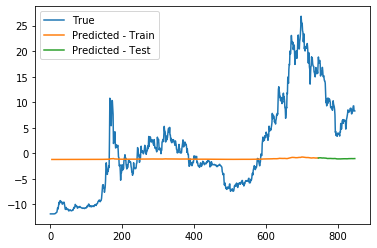

Epochs:  10  Iterations:  275  Loss:  28.772887110710144


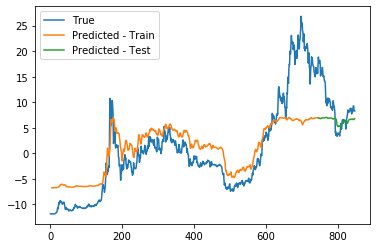

Epochs:  20  Iterations:  525  Loss:  7.435375194549561


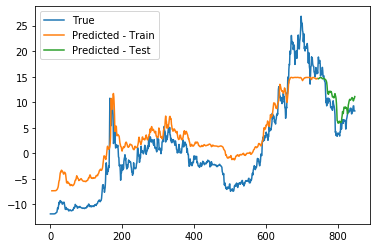

Epochs:  30  Iterations:  775  Loss:  4.708232481330633


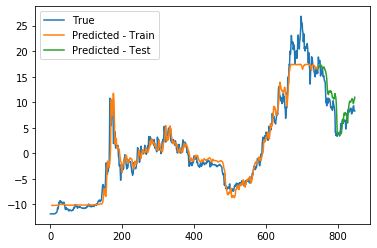

Epochs:  40  Iterations:  1025  Loss:  3.3381727638840677


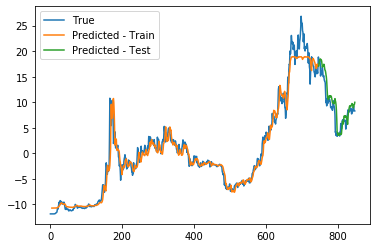

Epochs:  50  Iterations:  1275  Loss:  3.000216992944479


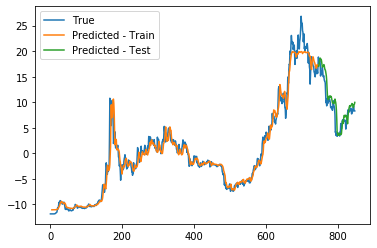

Epochs:  60  Iterations:  1525  Loss:  2.8046743655204773


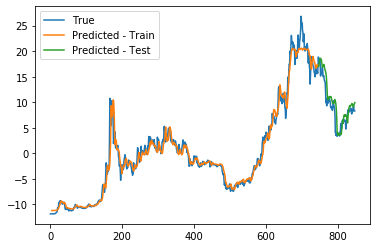

Epochs:  70  Iterations:  1775  Loss:  2.645231502652168


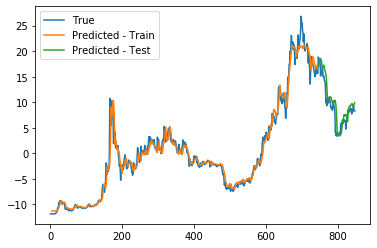

Epochs:  80  Iterations:  2025  Loss:  2.487245098054409


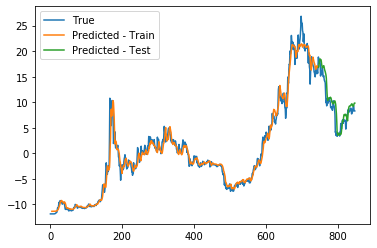

Epochs:  90  Iterations:  2275  Loss:  2.3436125080287455


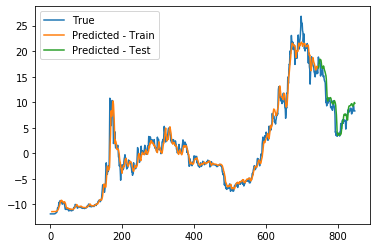

Epochs:  100  Iterations:  2525  Loss:  2.222186710983515


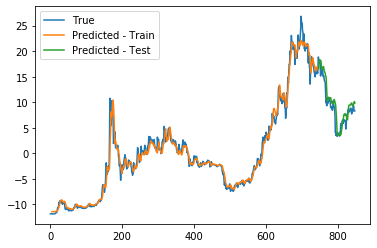

Finished Training


In [8]:
# Read dataset
print("==> Load dataset ...")
X, y = read_data(dataroot, debug=False)

# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    X,
    y,
    ntimestep,
    nhidden_encoder,
    nhidden_decoder,
    batchsize,
    lr,
    epochs
)

# Train
print("==> Start training ...")
model.train()

# Prediction
y_pred = model.test()

fig1 = plt.figure()
plt.semilogy(range(len(model.iter_losses)), model.iter_losses)
plt.savefig("1.png")
plt.close(fig1)

fig2 = plt.figure()
plt.semilogy(range(len(model.epoch_losses)), model.epoch_losses)
plt.savefig("2.png")
plt.close(fig2)
fig3 = plt.figure()
plt.plot(y_pred, label='Predicted')
plt.plot(model.y[model.train_timesteps:], label="True")
plt.legend(loc='upper left')
plt.savefig("3.png")
plt.close(fig3)
print('Finished Training')

In [9]:
(y_pred-model.y[model.train_timesteps:]).astype(int)

array([-2, -1,  0,  0,  0,  0,  2,  1,  1,  1,  0,  0,  0,  1,  1,  1,  1,
        1,  1,  1,  3,  5,  3,  3,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        1,  1,  1,  0,  1,  1,  0,  0,  0,  1,  1,  1,  2,  5,  4,  4,  3,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -2, -1,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  0,  0,  0, -1,  0,  0,  1,
        1,  1,  1,  0,  0,  0,  1,  2,  2,  0,  1,  0,  0,  0,  1,  1,  1])

In [10]:
from sklearn.metrics import mean_squared_error
mean_squared_error(model.y[model.train_timesteps:], y_pred)

2.8489125717731283

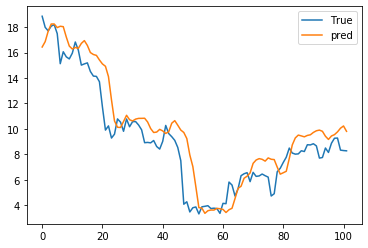

In [11]:
plt.plot(model.y[model.train_timesteps:], label="True")
plt.plot(y_pred,label="pred")
plt.legend()
plt.show()

In [12]:
len(y_pred)

102